# Seattle Airbnb Data

The data I used in this notebook refer to over 3800 accommodations that where enlisted to Airbnb in Seattle during 2016. They describe a wide variety of features: not only information about hosts, locations and fares applied to each listing, but also their average ratings and availability period. These datasets are available for free download at https://www.kaggle.com/datasets/airbnb/seattle, where you can find more details and other interesting studies about them.

## How much ratings depend on prices and availability?

Second, I wonder if the price required for a one-night stay affects ratings scores. Do guests evaluate cheaper rooms worse or do them enjoy discount fares?  

### Imports

Read the necessary libraries and import data from ***listings.csv*** and ***calendar.csv*** files

##### Import Python Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

##### Import Datasets

In [2]:
df_listings = pd.read_csv('./listings.csv')
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [3]:
df_calendar = pd.read_csv('./calendar.csv')
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


### Data Exploration and Data Quality Adjustments

##### Listings Dataset

Select from **listings** dataset the fields:
- review_scores_rating (where ratings are stored)
- id (necessary to merge with **calendar** dataset)

In [4]:
df_listings_subset = df_listings[['id', 'review_scores_rating']]

##### Calendar Dataset

All fields in **calendar**
In order to compare rating to price is firt necessary to transform data in price field in numeric format dataset as useful for our study

In order to use the **price** field is first necessary to transform data in price field in numeric format

In [5]:
df_calendar['price'] = df_calendar['price'].replace(regex=[r'\$', r','], value='').astype('float64')

Since the availability record stored in the field **available**, while being logically boolean is indeed a string, we have to convert is format by encoding

In [6]:
df_calendar['available'] = pd.get_dummies(df_calendar['available'], drop_first=True)

### Grouping and Merging Datasets

Since the day by day record for listings is out of the scope of our analysis, we group the data in **calendar** dataset by listing.

Then we merge both dataset using **listing_id** as key for the merge.

In [7]:
df_availability = df_calendar.groupby(by = ['listing_id']).sum()
df_availability['price'] = df_availability['price']/df_availability['available']
df_availability

,available,price
listing_id,,
3335,309.0,120.000000
4291,365.0,82.000000
5682,309.0,53.944984
6606,365.0,92.849315
7369,53.0,85.000000
...,...,...
10332096,365.0,40.000000
10334184,361.0,120.000000
10339144,0.0,NaN


In [8]:
df_merged = df_listings_subset.merge(df_availability, how = 'left', left_on='id', right_on='listing_id')

In [9]:
df_merged.head()

,id,review_scores_rating,available,price
0,241032,95.0,346.0,85.000000
1,953595,96.0,291.0,170.931271
2,3308979,97.0,220.0,1301.818182
3,7421966,NaN,143.0,100.000000
4,278830,92.0,365.0,462.739726


### Pre-Processing

#### Remove records with average rating missing

Since we are interested in studying the rating scores of the listings, we can remove from the dataset all listings that are not rated

In [10]:
df_merged.isnull().mean()

id                      0.000000
review_scores_rating    0.169460
available               0.000000
price                   0.024882
dtype: float64

In [11]:
df_rated = df_merged.dropna(subset = ['review_scores_rating'])

#### Transform quantitative columns in categorical

Since our aim is to study if in general prices and availability have some influence on the rating scores, we must deal with these dimesions as categorical variables.

##### Price

In order to store price data in a categorical column I split the listings in 15 tiers of price.

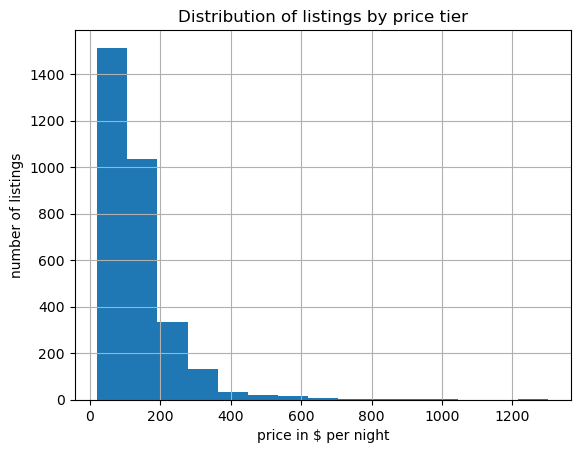

In [12]:
ax = df_rated.price.hist(bins=15);
ax.set_xlabel("price in $ per night")
ax.set_ylabel("number of listings")
plt.title("Distribution of listings by price tier");

As the distiribution of listings on the price tiers is very skewed toward lower values, I grouped in an only tier all listings with prices higher than 300$ per night 

In [13]:
capped_price = pd.DataFrame({'col1': df_rated['price'], 'col2': [300 for i in df_rated.index]}).min(axis=1)

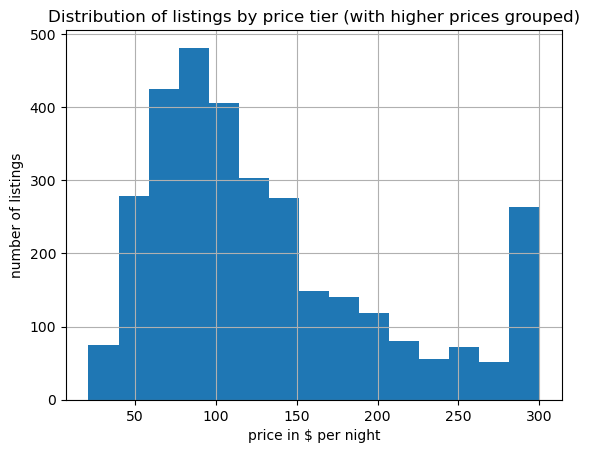

In [14]:
ax = capped_price.hist(bins = 15);
ax.set_xlabel("price in $ per night")
ax.set_ylabel("number of listings")
plt.title("Distribution of listings by price tier (with higher prices grouped)");

Define the price tiers and add the new categorical field to the dataset

In [15]:
df_rated['price_tiers'] = pd.DataFrame({'col1': (df_rated['price']//20)*20, 'col2': [300 for i in df_rated.index]}).min(axis=1)

C:\Users\2100\AppData\Local\Temp\ipykernel_11292\601027128.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rated['price_tiers'] = pd.DataFrame({'col1': (df_rated['price']//20)*20, 'col2': [300 for i in df_rated.index]}).min(axis=1)


In [16]:
df_rated['price_tiers'] = (df_rated['price_tiers'].astype(int).astype(str) + " $").str.zfill(5)

C:\Users\2100\AppData\Local\Temp\ipykernel_11292\2474955071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rated['price_tiers'] = (df_rated['price_tiers'].astype(int).astype(str) + " $").str.zfill(5)


##### Availability

In order to store availability data in a categorical column I split the listings in 12 tiers of availability.

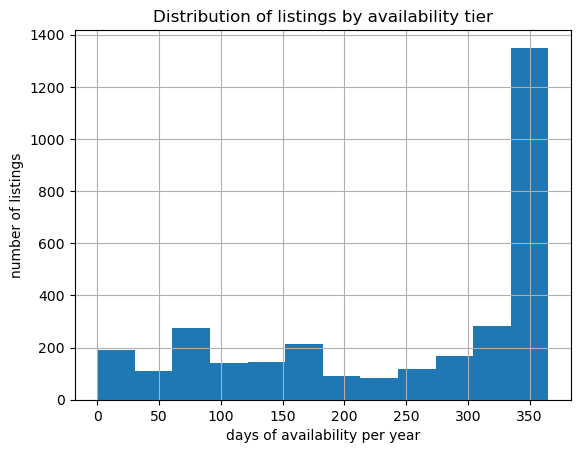

In [17]:
ax = df_rated.available.hist(bins=12);
ax.set_xlabel("days of availability per year")
ax.set_ylabel("number of listings")
plt.title("Distribution of listings by availability tier");

Define the availability tiers and add the new categorical field to the dataset

In [18]:
df_rated['availability_tiers'] = pd.DataFrame({'col1': df_rated['available']//30*30, 'col2': [360 for i in df_rated.index]}).min(axis=1)

C:\Users\2100\AppData\Local\Temp\ipykernel_11292\1186337729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rated['availability_tiers'] = pd.DataFrame({'col1': df_rated['available']//30*30, 'col2': [360 for i in df_rated.index]}).min(axis=1)


In [19]:
df_rated['availability_tiers'] = (df_rated['availability_tiers'].astype(int).astype(str) + " days per year").str.zfill(17)

C:\Users\2100\AppData\Local\Temp\ipykernel_11292\1431809021.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rated['availability_tiers'] = (df_rated['availability_tiers'].astype(int).astype(str) + " days per year").str.zfill(17)


In [20]:
df_rated

,id,review_scores_rating,available,price,price_tiers,availability_tiers
0,241032,95.0,346.0,85.000000,080 $,330 days per year
1,953595,96.0,291.0,170.931271,160 $,270 days per year
2,3308979,97.0,220.0,1301.818182,300 $,210 days per year
4,278830,92.0,365.0,462.739726,300 $,360 days per year
5,5956968,95.0,302.0,125.629139,120 $,300 days per year
...,...,...,...,...,...,...
3810,262764,92.0,227.0,191.651982,180 $,210 days per year
3811,8578490,100.0,221.0,67.782805,060 $,210 days per year
3812,3383329,96.0,287.0,102.818815,100 $,270 days per year
3813,8101950,80.0,32.0,359.000000,300 $,030 days per year


### How much ratings depend on prices?

Define a dataframe to store statistics for each price tier.

In [21]:
avg_rating_by_price = df_rated.groupby(['price_tiers'])['review_scores_rating'].mean()
avg_rating_by_price

price_tiers
020 $    93.200000
040 $    94.013115
060 $    94.619780
080 $    94.439394
100 $    94.056410
120 $    94.435737
140 $    94.858333
160 $    94.704142
180 $    94.913043
200 $    94.905263
220 $    95.250000
240 $    94.316456
260 $    95.210526
280 $    94.878788
300 $    95.519149
Name: review_scores_rating, dtype: float64

The following chart represents the average rating scores for any price tier.

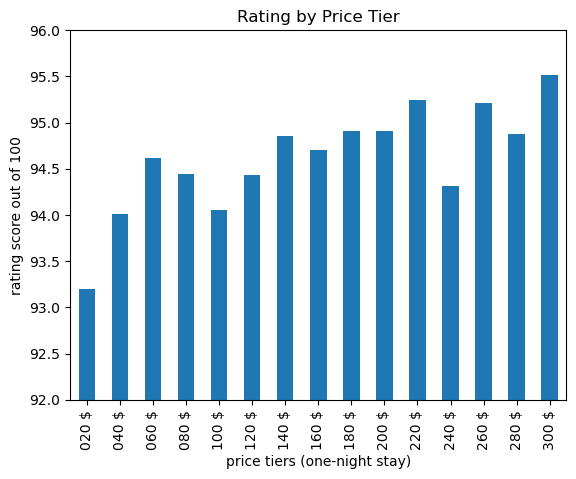

In [22]:
ax = avg_rating_by_price.plot.bar(y = 'review_scores_rating', legend=False)
ax.set_xlabel("price tiers (one-night stay)")
ax.set_ylabel("rating score out of 100")
ax.set_ylim(92,96)
plt.title("Rating by Price Tier");

### How much ratings depend on availability?

Define a dataframe to store statistics for each availability tier.

In [23]:
avg_rating_by_availability = df_rated.groupby(['availability_tiers'])['review_scores_rating'].mean()
avg_rating_by_availability

availability_tiers
000 days per year    93.919355
030 days per year    95.044643
060 days per year    94.479554
090 days per year    95.335878
120 days per year    95.760274
150 days per year    95.228700
180 days per year    93.418605
210 days per year    95.543210
240 days per year    96.258621
270 days per year    94.205479
300 days per year    95.033195
330 days per year    94.943396
360 days per year    93.338255
Name: review_scores_rating, dtype: float64

The following chart represents the average rating scores for any availability tier.

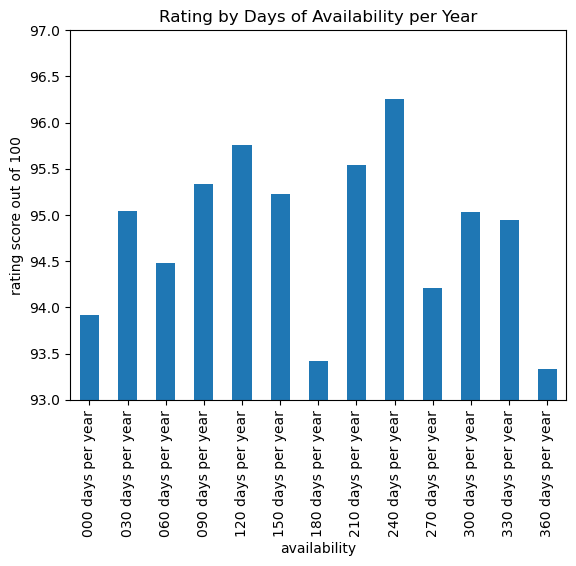

In [24]:
ax = avg_rating_by_availability.plot.bar(y = 'review_scores_rating', legend=False)
ax.set_xlabel("availability")
ax.set_ylabel("rating score out of 100")
ax.set_ylim(93,97)
plt.title("Rating by Days of Availability per Year");